# HW2

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#HW2-1 Naive Bayes classifier

## Def read file

In [ ]:
import numba as nb
import numpy as np
import math

In [ ]:
def Load():
    import gzip
    train_labels = '/content/gdrive/MyDrive/01_GMBA/3rd_semester(2022)/01-2_PM & 04-1_Machine Learning/HW2_1023/train-labels-idx1-ubyte.gz'
    train_images = '/content/gdrive/MyDrive/01_GMBA/3rd_semester(2022)/01-2_PM & 04-1_Machine Learning/HW2_1023/train-images-idx3-ubyte.gz'
    label_file = gzip.open(train_labels, "r") #("train-labels.idx1-ubyte", "rb") 
    image_file = gzip.open(train_images, "r") #("train-images.idx3-ubyte", "rb")

    # magic number + number of images ；magic number我們不使用，但還是要read，不然無法讀後面的資料
    # number of images 在label files 與 image files 個數是一樣的，故只讀image file的就可以
    label_file.read(8) 
    image_file.read(4) #magic number ；magic number我們不使用，但還是要read，不然無法讀後面的資料
    number = int.from_bytes(image_file.read(4), byteorder='big') # number of images
    row = int.from_bytes(image_file.read(4), byteorder='big') # number of rows
    column = int.from_bytes(image_file.read(4), byteorder='big') # number of columns

    trainingLabel = np.zeros(number, dtype=int)
    trainingData = np.zeros((number, row, column), dtype=int)

    for i in range(number):
        trainingLabel[i] = label_file.read(1)[0]
        for j in range(row):
            for k in range(column):
                trainingData[i][j][k] = image_file.read(1)[0]

    label_file.close()
    image_file.close()

    test_labels = '/content/gdrive/MyDrive/01_GMBA/3rd_semester(2022)/01-2_PM & 04-1_Machine Learning/HW2_1023/dataset/t10k-labels-idx1-ubyte.gz'
    test_images = '/content/gdrive/MyDrive/01_GMBA/3rd_semester(2022)/01-2_PM & 04-1_Machine Learning/HW2_1023/dataset/t10k-images-idx3-ubyte.gz'
    label_file = gzip.open(test_labels, "r")
    image_file = gzip.open(test_images, "r")

    label_file.read(8)
    image_file.read(4)
    number = int.from_bytes(image_file.read(4), byteorder='big')
    row = int.from_bytes(image_file.read(4), byteorder='big')
    column = int.from_bytes(image_file.read(4), byteorder='big')

    testLabel = np.zeros(number, dtype=int)
    testData = np.zeros((number, row, column), dtype=int)
    for i in range(number):
        testLabel[i] = label_file.read(1)[0]
        for j in range(row):
            for k in range(column):
                testData[i][j][k] = image_file.read(1)[0]

    label_file.close()
    image_file.close()

    return trainingLabel, trainingData, testLabel, testData

## Discrete

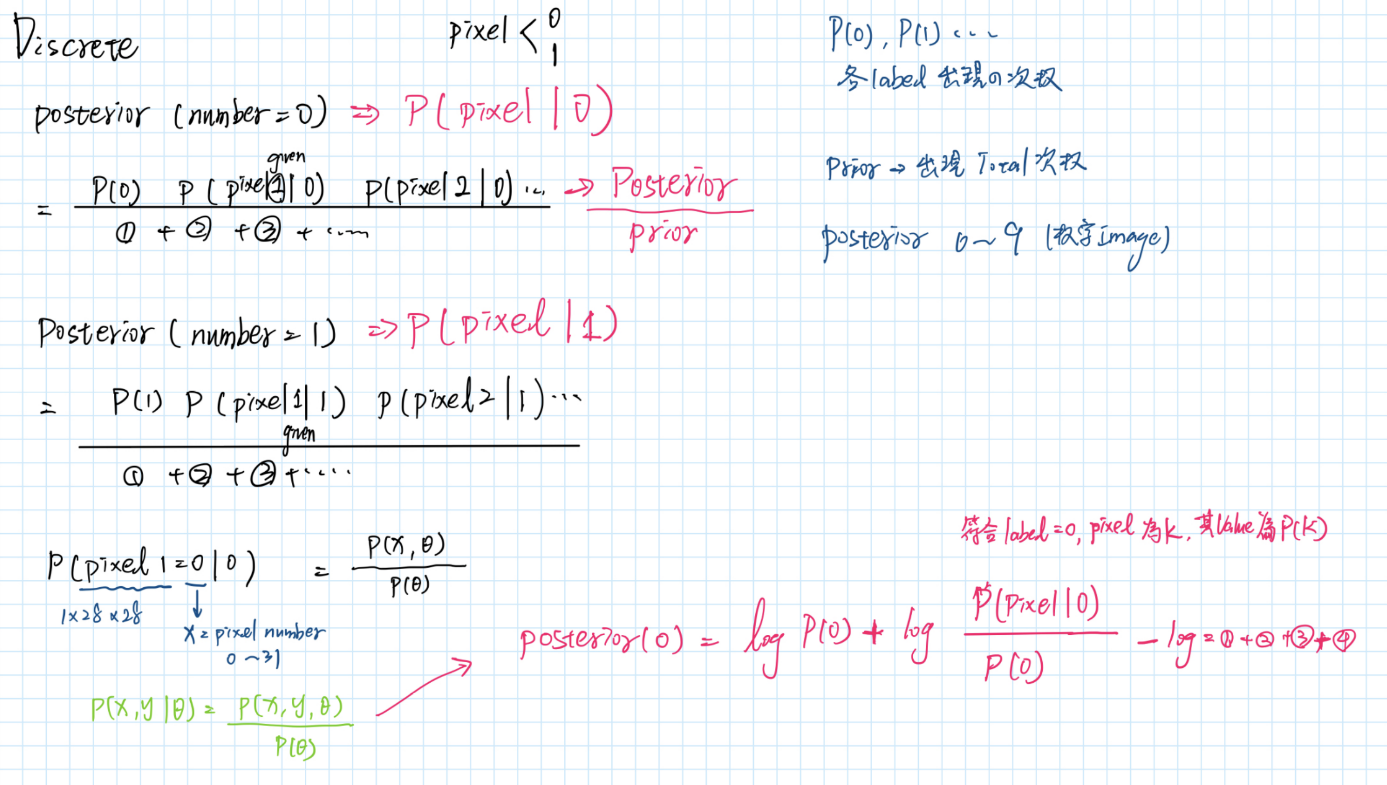

In [ ]:
def Discrete(labels, data):
    prior = np.zeros(10)
    likelihood = np.ones((10, 28, 28, 32))

    for i in range(len(labels)):
        prior[labels[i]] += 1
        for j in range(28):
            for k in range(28):
                pixel = data[i][j][k] #1*28*28
                likelihood[labels[i]][j][k][int(pixel/8)] += 1

    for i in range(10):
        for j in range(28): 
            for k in range(28):
                for l in range(32):
                    likelihood[i][j][k][l] = likelihood[i][j][k][l] / prior[i]
    return prior/60000, likelihood

## Continue

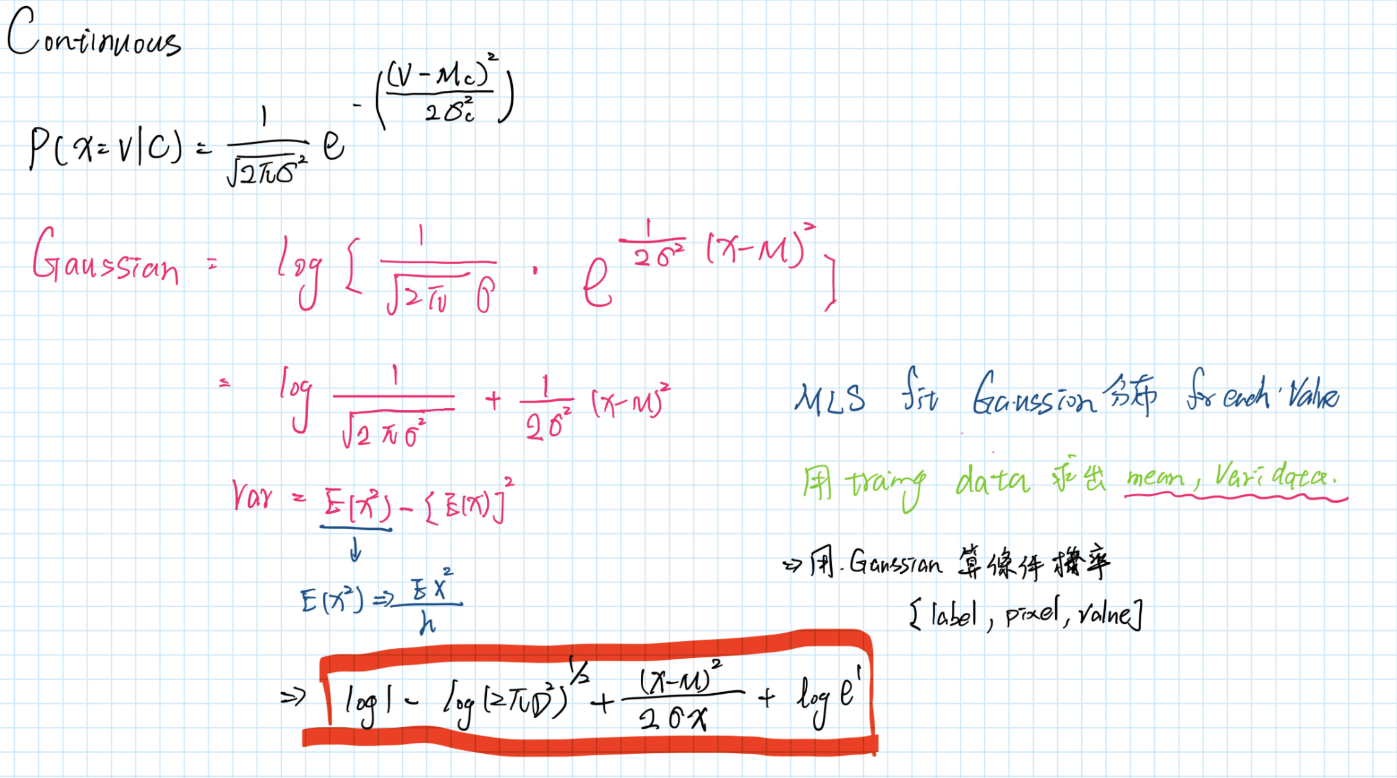

In [ ]:
def Continue(labels, data):
    prior = np.zeros(10)
    Gaussian = np.zeros((10, 28, 28, 2)) # 2 means mean and variance

    for i in range(len(labels)):
        label = labels[i]
        for j in range(28):
            for k in range(28):
                pixel = data[i][j][k]
                Gaussian[label][j][k][0] = (prior[label]/(prior[label]+1)) * Gaussian[label][j][k][0] + pixel / (prior[label]+1)
                Gaussian[label][j][k][1] = (prior[label]/(prior[label]+1)) * Gaussian[label][j][k][1] + (pixel**2) / (prior[label]+1)
        prior[label] += 1

    for i in range(10):
        for j in range(28):
            for k in range(28):
                Gaussian[i][j][k][1] -= Gaussian[i][j][k][0]**2

    return prior/60000, Gaussian

##test

In [ ]:
def test(mode, labels, data):
    err = 0.

    posterior = np.zeros((len(labels), 10))
    predictions = np.zeros(len(labels))
    answers = np.zeros(len(labels))
    for image_index in range(len(labels)):
        # Calculate posterior
        for label in range(10):
            posterior[image_index] += np.log10(prior[label])
            for i in range(28):
                for j in range(28):
                    if mode == 0:
                        posterior[image_index][label] += np.log10(likelihood[label][i][j][int(data[image_index][i][j]/8)])
                    elif mode == 1:
                        mean = likelihood[label][i][j][0]
                        variance = likelihood[label][i][j][1]
                        if variance != 0:
                            posterior[image_index][label] += -0.5 * math.log10(2 * math.pi * variance) - math.log10(math.exp(1)) * ((data[image_index][i][j] - mean) ** 2) / (2 * variance)
        predictions[image_index] = np.argmax(posterior[image_index])
        answers[image_index] = labels[image_index]
        if predictions[image_index] != answers[image_index]:
            err += 1

    return posterior, predictions, answers, err/len(labels)

## Print Result

In [ ]:
def Print_Result(likelihood, posterior, predictions, answers, err):
    result = ""

    for image_index in range(len(predections)):
        result += "Posterior (in log scale):\n"
        for label in range(10):
            result += f"{label}: {posterior[image_index][label]/np.sum(posterior[image_index])}\n"
        result += f"Prediction: {predictions[image_index]}, Ans: {answers[image_index]}\n\n"

    # Print Bayesian classifier
    result += "Imagination of numbers in Bayesian classifier:"
    for label in range(10):
        result += f"\n{label}:\n"
        for i in range(28):
            for j in range(28):
                if mode == 0:
                    classifier_value = np.argmax(likelihood[label][i][j])
                    result += f"{int(classifier_value/16)} "
                elif mode == 1:
                    classifier_value = likelihood[label][i][j][0]   # The MLE of likelihood is mean
                    result += f"{int(classifier_value/128)} "
            result += "\n"

    result += f"Error rate: {err}"

    return result

In [ ]:
mode = int(input("Toggle option is (0 or 1): "))

# loading
print("Loading the data")
trainingLabel, trainingData, testLabel, testData = Load()

# training
print("Training process")
if mode == 0:
    prior, likelihood = Discrete(trainingLabel, trainingData)
elif mode == 1:
    prior, likelihood = Continue(trainingLabel, trainingData)

# testing
print("Testing process")
posterior, predections, answers, err = test(mode, testLabel, testData)

if mode == 0:
  resultFile = open("result_Toggle_0.txt", 'w')
elif mode == 1:
  resultFile = open("result_Toggle_1.txt", 'w')
resultFile.write(Print_Result(likelihood, posterior, predections, answers, err))

Toggle option is (0 or 1): 1
Loading...
Training...
Testing...


2906805

# HW2-2 Online learning


In [ ]:
import math
import numpy as np
from matplotlib import pyplot

In [16]:
testcase = '/content/gdrive/MyDrive/01_GMBA/3rd_semester(2022)/01-2_PM & 04-1_Machine Learning/HW2_1023/dataset/testcase.txt'
testFile = open(testcase, 'r')
line = testFile.readline().replace('\n','')
print("Input initial parameter:")
a_prior = int(input("a = "))
b_prior = int(input("b = "))
a_posterior = 0
b_posterior = 0
caseCount = 1

while line:
    count_1 = line.count("1")
    count_0 = line.count("0")
    a_posterior = a_prior + count_1
    b_posterior = b_prior + count_0

    p_MLE = count_1 / (count_1 + count_0)
    likelihood = math.factorial(count_0 + count_1)/(math.factorial(count_0) * math.factorial(count_1))
    likelihood = likelihood * (p_MLE ** count_1) * ((1 - p_MLE) ** count_0)

    print(f"\nCase {caseCount}:", line)
    print("Likelihood:", likelihood)
    print(f"Beta Prior:     a = {a_prior}, b = {b_prior}")
    print(f"Beta posterior: a = {a_posterior}, b = {b_posterior}")

    # Draw plot
    if (a_prior * b_prior) != 0:
        Beta = math.factorial(a_prior + b_prior - 1)/(math.factorial(a_prior - 1) * math.factorial(b_prior - 1))

    Beta = math.factorial(count_0 + count_1)/(math.factorial(count_0) * math.factorial(count_1))

    if (a_posterior * b_posterior) != 0:
        Beta = math.factorial(a_posterior + b_posterior - 1)/(math.factorial(a_posterior - 1) * math.factorial(b_posterior - 1))

    a_prior = a_posterior
    b_prior = b_posterior
    line = testFile.readline().replace('\n','')
    caseCount += 1

Input initial parameter:
a = 0
b = 0

Case 1: 0101010101001011010101
Likelihood: 0.16818809509277344
Beta Prior:     a = 0, b = 0
Beta posterior: a = 11, b = 11

Case 2: 0110101
Likelihood: 0.29375515303997485
Beta Prior:     a = 11, b = 11
Beta posterior: a = 15, b = 14

Case 3: 010110101101
Likelihood: 0.2286054241794335
Beta Prior:     a = 15, b = 14
Beta posterior: a = 22, b = 19

Case 4: 0101101011101011010
Likelihood: 0.18286870706509092
Beta Prior:     a = 22, b = 19
Beta posterior: a = 33, b = 27

Case 5: 111101100011110
Likelihood: 0.2143070548857833
Beta Prior:     a = 33, b = 27
Beta posterior: a = 43, b = 32

Case 6: 101110111000110
Likelihood: 0.20659760529408
Beta Prior:     a = 43, b = 32
Beta posterior: a = 52, b = 38

Case 7: 1010010111
Likelihood: 0.25082265600000003
Beta Prior:     a = 52, b = 38
Beta posterior: a = 58, b = 42

Case 8: 11101110110
Likelihood: 0.2619678932864457
Beta Prior:     a = 58, b = 42
Beta posterior: a = 66, b = 45

Case 9: 01000111101
Likelih